<br>
<font>
<div dir=ltr align=center>

<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    NLP - Skip-Gram <br>
<font color=0CBCDF size=4>
  
</div>

____

In [ ]:
import io
import math
import gzip
import nltk
import time
import random
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_datasets as tfds
nltk.download('stopwords')

from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Downloading Dataset
We're going to use text8 dataset. Text8 is first 100,000,000 bytes of plain text from Wikipedia. It's mainly used for testing purposes.

In [ ]:
def load_data():
  text8_zip_file_path = api.load('text8', return_path=True)
  with gzip.open(text8_zip_file_path, 'rb') as file:
    file_content = file.read()
  wiki = file_content.decode()
  return wiki

wiki = load_data()

### Preprocessing data

**Stopwords removal** - Begin by removing stopwords from the dataset, as they provide little to no value in learning word embeddings. Ensure your preprocessing pipeline filters out commonly used words such as "the," "and," or "of" that do not contribute to meaningful semantic relationships.

---

**Subsampling words** - In a large corpora, most frequent words can easily occur hundreds of millions of times and such words usually don't bring much information to the table.  It is of essential importance to cut down on their frequencies to mitigate the negative impact it adds. For example, co-occurrences of "English" and "Spanish" benefit much more than co-occurrences of "English" and "the" or "Spanish" and "of". To counter the imbalance between rare and frequent words Mikolov et. al came up with the following heuristic formula for determining probability to drop a particular word:

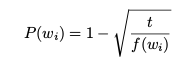

where t is threshold value (heuristically set to 1e-5) and f(w) is frequency of the word.

Implement a subsampling mechanism to handle overly frequent words in the corpus. Use the heuristic formula provided by Mikolov et al. to calculate the probability of dropping a word based on its frequency. This step ensures the corpus maintains a balance between rare and frequent words, improving the quality of word co-occurrence relationships.

---

**Filtering words** - Filter out words that occur only once in the dataset, as they lack sufficient context to be represented effectively. Retain only those words that appear at least five times in the corpus to minimize noise and enhance the overall quality of the embeddings.


In [ ]:
import re
from collections import Counter

def preprocess_text(text):
    text = text.replace('.', ' . ').replace(',', ' , ').replace(';', ' ; ').replace(':', ' : ')
    text = text.lower().strip()
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word not in stop_words]
    word_counts = Counter(words)
    words = [word for word in words if word_counts[word] >= 5]
    total_count = sum(word_counts.values())
    threshold = 1e-5
    word_probabilities = {
        word: 1 - math.sqrt(threshold / (count / total_count))
        for word, count in word_counts.items()
    }
    words = [word for word in words if random.random() > word_probabilities.get(word, 0)]
    return words, word_counts


It's always a good idea to take a quick look at preprocessed sample before heading further - you might observe few things that if handled can enrich or correct your data. More like a validation step this.

In [ ]:
sample = wiki[:10000]
print(len(wiki))
processed_texts,count_words = preprocess_text(sample)
print(processed_texts)
print(sample)
print(list(count_words.items())[:10])


100000000
['state', 'anarchist', 'anarchist', 'modern', 'eight', 'anarchists', 'anarchist']
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

### Hyperparameters
Setting a few hyperparamters required for gnerating batches and for deciding the size of word embeddings.



In [ ]:
EMBEDDING_DIM = 128
BUFFER_SIZE = 10000
BATCH_SIZE = 512
EPOCHS = 5
WINDOW_SIZE = 5

### Preparing TensorFlow Dataset using Skipgrams

**Generating Skipgrams**

Tokenize your preprocessed textual data and convert the words into their corresponding vectorized tokens. Then, use the `skipgrams` function provided by Keras to generate (word, context) pairs. Ensure the following steps are completed:

- Generate positive samples: (word, word in the same window), with label 1.  
- Generate negative samples: (word, random word from the vocabulary), with label 0.  

Refer to Mikolov et al.'s paper, [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf), for more details on Skipgrams.

---

**Negative Sampling**

For each input word, implement the negative sampling approach to optimize the training process. Transform the problem of predicting context words into independent binary classification tasks. For every (target, context) pair, generate random negative (target, ~context) samples. This step will reduce computational complexity and make training more efficient.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams
index = int(len(wiki)/10)
print(index)
processed_words,_ = preprocess_text(wiki[:index])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_words)
vocab_mapping = tokenizer.word_index
vocab_count = len(vocab_mapping) + 1

token_sequences = tokenizer.texts_to_sequences([processed_words])[0]

pair_data, pair_labels = skipgrams(
    token_sequences,
    vocabulary_size=vocab_count,
    window_size=5,
    negative_samples=5,
)

word_targets, word_contexts = zip(*pair_data)
word_targets = np.array(word_targets, dtype=np.int32)
word_contexts = np.array(word_contexts, dtype=np.int32)
pair_labels = np.array(pair_labels, dtype=np.int32)

dataset_size = len(word_targets)
training_set_size = int(dataset_size * 0.8)
all_indices = np.arange(dataset_size)
np.random.shuffle(all_indices)

train_idx = all_indices[:training_set_size]
test_idx = all_indices[training_set_size:]

train_word_targets = word_targets[train_idx]
train_word_contexts = word_contexts[train_idx]
train_pair_labels = pair_labels[train_idx]

test_word_targets = word_targets[test_idx]
test_word_contexts = word_contexts[test_idx]
test_pair_labels = pair_labels[test_idx]

train_tf_dataset = tf.data.Dataset.from_tensor_slices(((train_word_targets, train_word_contexts), train_pair_labels))
train_tf_dataset = train_tf_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_tf_dataset = tf.data.Dataset.from_tensor_slices(((test_word_targets, test_word_contexts), test_pair_labels))
test_tf_dataset = test_tf_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


10000000


In [ ]:
print(f"size of training dataset: {len(list(train_tf_dataset))}")
print(f"size of test dataset: {len(list(test_tf_dataset))}")

size of training dataset: 29372
size of test dataset: 7343


### Building the Model

Use the model subclassing method to build your model. While Sequential and Functional APIs are generally more suitable for most use cases, model subclassing allows you to create the model in an object-oriented way. Follow these steps:

1. Define a custom model class by inheriting from `tf.keras.Model`.
2. Implement the `__init__` method to define the layers of your model.
3. Override the `call` method to define the forward pass of your model.
4. Ensure that the model includes embedding layers, a skip-gram architecture, and any other necessary components for training.


In [ ]:
class SkipGramModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.target_dense = tf.keras.layers.Dense(units=1, activation="sigmoid")

    def call(self, inputs):
        target, context = inputs
        target_embedding = self.embedding(target)
        context_embedding = self.embedding(context)
        dot_product = tf.reduce_sum(target_embedding * context_embedding, axis=-1)
        dot_product = tf.expand_dims(dot_product, axis=-1)  # Add an additional dimension
        output = self.target_dense(dot_product)
        return output

embedding_dim = EMBEDDING_DIM
model = SkipGramModel(vocab_size=vocab_count, embedding_dim=embedding_dim)

sample_target = tf.constant([1, 2, 3], dtype=tf.int32)
sample_context = tf.constant([4, 5, 6], dtype=tf.int32)
model_output = model((sample_target, sample_context))
print(model_output)


tf.Tensor(
[[0.50075924]
 [0.50163156]
 [0.50026256]], shape=(3, 1), dtype=float32)


### Loss function, Metrics and Optimizers

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

### Training the Model

Implement custom training for learning word embeddings to gain finer control over optimization and training tasks. Follow these steps:

1. Define a custom training loop that includes forward propagation, loss computation, and backpropagation.
2. Use the optimizer of your choice to update the model's weights based on the computed gradients.
3. Implement batching for efficient data processing during training.
4. Monitor the loss during each epoch to track the model's performance.
5. Save the trained embeddings for later use once the training is complete.

In [ ]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_acc_metric.update_state(labels, predictions)
    return loss

@tf.function
def test_step(inputs, labels):
    predictions = model(inputs)
    loss = loss_fn(labels, predictions)
    val_acc_metric.update_state(labels, predictions)
    return loss

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    for batch, ((target, context), labels) in enumerate(train_tf_dataset):
        loss = train_step((target, context), labels)
        if batch % 5000 == 0:
            print(f"Training loss (batch {batch}): {loss.numpy()}")

    train_accuracy = train_acc_metric.result()
    print(f"Training accuracy: {train_accuracy.numpy()}")
    train_acc_metric.reset_state()

    for ((target, context), labels) in test_tf_dataset:
        val_loss = test_step((target, context), labels)

    val_accuracy = val_acc_metric.result()
    print(f"Validation accuracy: {val_accuracy.numpy()}")
    val_acc_metric.reset_state()

    print("-------------------------------------------")


Epoch 1/5
Training loss (batch 0): 0.4321709871292114
Training loss (batch 5000): 0.359577476978302
Training loss (batch 10000): 0.3518892526626587
Training loss (batch 15000): 0.3748735189437866
Training loss (batch 20000): 0.2833389341831207
Training loss (batch 25000): 0.30349141359329224
Training accuracy: 0.8620156049728394
Validation accuracy: 0.8791515827178955
-------------------------------------------
Epoch 2/5
Training loss (batch 0): 0.2925770878791809
Training loss (batch 5000): 0.26350969076156616
Training loss (batch 10000): 0.2213103473186493
Training loss (batch 15000): 0.27283167839050293
Training loss (batch 20000): 0.26016175746917725
Training loss (batch 25000): 0.26193559169769287
Training accuracy: 0.8999175429344177
Validation accuracy: 0.8859329223632812
-------------------------------------------
Epoch 3/5
Training loss (batch 0): 0.21735258400440216
Training loss (batch 5000): 0.26437222957611084
Training loss (batch 10000): 0.21560600399971008
Training loss 

In [ ]:
checkpoint_prefix = "./chckpt/model"

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

checkpoint.save(file_prefix=checkpoint_prefix)
print(f"Weights saved to checkpoint at {checkpoint_prefix}")

Weights saved to checkpoint at ./chckpt/model


### Word Embeddings Projector

Follow these steps to visualize the learned word embeddings using TensorFlow's Embedding Projector:

1. Extract the weights of the embedding layer from your trained model.
2. Save the weights into two files:
   - `vecs.tsv`: This file will store the actual vector representations of words.
   - `meta.tsv`: This file will store the associated metadata (e.g., word labels) for visualization.
3. Go to [TensorFlow Embedding Projector](http://projector.tensorflow.org/).
4. Upload the `vecs.tsv` and `meta.tsv` files created in the previous step.
5. Explore the visualizations provided by TensorFlow's Embedding Projector.

</font>


In [ ]:
embedding_layer = model.embedding

embedding_weights = embedding_layer.get_weights()[0]

with open('vecs.tsv', 'w') as vecs_file, open('meta.tsv', 'w') as meta_file:

    for word, idx in tokenizer.word_index.items():
        embedding = embedding_weights[idx]
        vecs_file.write('\t'.join(map(str, embedding)) + '\n')
        meta_file.write(word + '\n')


print("Embeddings and metadata have been saved.")

Embeddings and metadata have been saved.
